# 反向传播算法实战

我们将实现一个 `4` 层的全连接网络，来完成二分类任务。网络输入节点数为 `2`，隐藏 层的节点数设计为：`25、50`和`25`，输出层两个节点，分别表示属于类别 `1` 的概率和类别 `2` 的概率，如下图所示。这里并没有采用 `Softmax` 函数将网络输出概率值之和进行约束， 而是直接利用均方误差函数计算与 `One-hot` 编码的真实标签之间的误差，所有的网络激活 函数全部采用 `Sigmoid` 函数，这些设计都是为了能直接利用我们的梯度传播公式。 

![](https://i.postimg.cc/4dypfbvF/screenshot-24.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split

### 1. 准备数据

In [2]:
X, y = datasets.make_moons(n_samples=1000, noise=0.2, random_state=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X.shape, y.shape)  # (1000, 2) (1000,)

(1000, 2) (1000,)


In [3]:
def make_plot(X, y, plot_name):
    plt.figure(figsize=(12, 8))    
    plt.title(plot_name, fontsize=30)     
    plt.scatter(X[y==0, 0], X[y==0, 1])
    plt.scatter(X[y==1, 0], X[y==1, 1])

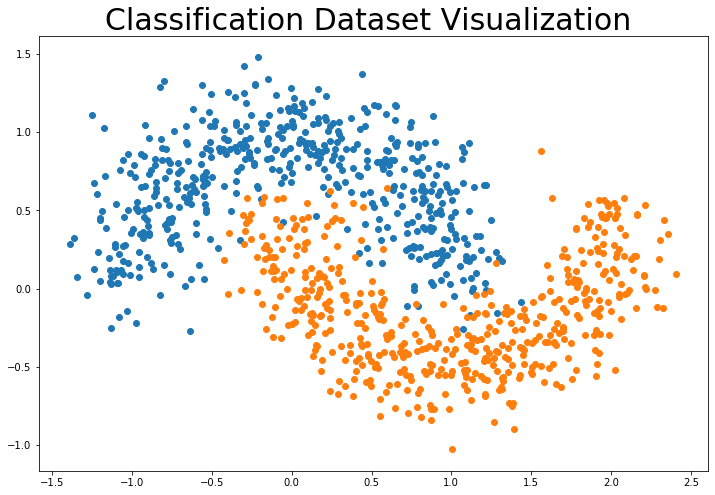

In [4]:
make_plot(X, y, "Classification Dataset Visualization ") 

### 2. 网络层
- 通过新建类 `Layer` 实现一个网络层，需要传入网络层的输入节点数、输出节点数、激 活函数类型等参数
- 权值 `weights` 和偏置张量 `bias` 在初始化时根据输入、输出节点数自动 生成并初始化

In [5]:
class Layer:
    # 全链接网络层
    def __init__(self, n_input, n_output, activation=None, weights=None, bias=None):
        """
        :param int n_input: 输入节点数 
        :param int n_output: 输出节点数         
        :param str activation: 激活函数类型         
        :param weights: 权值张量，默认类内部生成         
        :param bias: 偏置，默认类内部生成 
        """
        self.weights = weights if weights is not None else np.random.randn(n_input, n_output) * np.sqrt(1 / n_output) 
        self.bias = bias if bias is not None else np.random.rand(n_output) * 0.1
        self.activation = activation # 激活函数类型，如’sigmoid’         
        self.activation_output = None # 激活函数的输出值 o         
        self.error = None  # 用于计算当前层的 delta 变量的中间变量 
        self.delta = None  # 记录当前层的 delta 变量，用于计算梯度 
    
    def activate(self, X):
        # 前向计算函数
        r = np.dot(X, self.weights) + self.bias # X@W + b
        # 通过激活函数，得到全连接层的输出 o (activation_output)      
        self.activation_output = self._apply_activation(r) 
        return self.activation_output
    
    def _apply_activation(self, r): # 计算激活函数的输出
        if self.activation is None:
            return r # 无激活函数，直接返回
        elif self.activation == 'relu':
            return np.maximum(r, 0)
        elif self.activation == 'tanh':
            return np.tanh(r)
        elif self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-r))
        
        return r
    
    def apply_activation_derivative(self, r):
        # 计算激活函数的导数
        # 无激活函数， 导数为 1
        if self.activation is None:
            return np.ones_like(r)
        # ReLU 函数的导数
        elif self.activation == 'relu':             
            grad = np.array(r, copy=True)             
            grad[r > 0] = 1.             
            grad[r <= 0] = 0.             
            return grad
        # tanh 函数的导数实现         
        elif self.activation == 'tanh':             
            return 1 - r ** 2 
        # Sigmoid 函数的导数实现         
        elif self.activation == 'sigmoid': 
            return r * (1 - r)
        return r

### 3. 网络模型
- 创建单层网络类后，我们实现网络模型的 `NeuralNetwork` 类
- 它内部维护各层的网络 层 `Layer` 类对象，可以通过 `add_layer` 函数追加网络层，
- 实现创建不同结构的网络模型目 的。

In [6]:
y_test.flatten().shape # (300,)

(300,)

In [7]:
class NeuralNetwork:
    def __init__(self):
        self._layers = [] # 网络层对象列表
    
    def add_layer(self, layer):
        self._layers.append(layer)
    
    def feed_forward(self, X):
        # 前向传播（求导）
        for layer in self._layers:
            X = layer.activate(X)
        return X
    
    def backpropagation(self, X, y, learning_rate):
        # 反向传播算法实现
        # 向前计算，得到最终输出值
        output = self.feed_forward(X)
        for i in reversed(range(len(self._layers))): # 反向循环
            layer = self._layers[i]
            if layer == self._layers[-1]: # 如果是输出层
                layer.error = y - output
                # 计算最后一层的 delta，参考输出层的梯度公式
                layer.delta = layer.error * layer.apply_activation_derivative(output)
            else: # 如果是隐藏层
                next_layer = self._layers[i + 1]
                layer.error = np.dot(next_layer.weights, next_layer.delta)
                layer.delta = layer.error*layer.apply_activation_derivative(layer.activation_output)
        
        # 循环更新权值
        for i in range(len(self._layers)):
            layer = self._layers[i]
            # o_i 为上一网络层的输出
            o_i = np.atleast_2d(X if i == 0 else self._layers[i - 1].activation_output)
            # 梯度下降算法，delta 是公式中的负数，故这里用加号 
            layer.weights += layer.delta * o_i.T * learning_rate 
    
    def train(self, X_train, X_test, y_train, y_test, learning_rate, max_epochs):
        # 网络训练函数
        # one-hot 编码
        y_onehot = np.zeros((y_train.shape[0], 2)) 
        y_onehot[np.arange(y_train.shape[0]), y_train] = 1
        mses = [] 
        for i in range(max_epochs):  # 训练 100 个 epoch             
            for j in range(len(X_train)):  # 一次训练一个样本                 
                self.backpropagation(X_train[j], y_onehot[j], learning_rate)             
                if i % 10 == 0: 
                    # 打印出 MSE Loss                 
                    mse = np.mean(np.square(y_onehot - self.feed_forward(X_train)))                 
                    mses.append(mse)                 
                    print('Epoch: #%s, MSE: %f, Accuracy: %.2f%%' % 
                          (i, float(mse), self.accuracy(self.predict(X_test), y_test.flatten()) * 100)) 

        return mses
    
    def accuracy(self, y_predict, y_test): # 计算准确度
        return np.sum(y_predict == y_test) / len(y_test)
    
    def predict(self, X_predict):
        y_predict = self.feed_forward(X_predict) # 此时的 y_predict 形状是 [600 * 2]，第二个维度表示两个输出的概率
        y_predict = np.argmax(y_predict, axis=1)
        return y_predict        

### 4. 网络训练

In [8]:
nn = NeuralNetwork() # 实例化网络类 
nn.add_layer(Layer(2, 25, 'sigmoid'))  # 隐藏层 1, 2=>25 
nn.add_layer(Layer(25, 50, 'sigmoid')) # 隐藏层 2, 25=>50 
nn.add_layer(Layer(50, 25, 'sigmoid')) # 隐藏层 3, 50=>25 
nn.add_layer(Layer(25, 2, 'sigmoid'))  # 输出层, 25=>2 

In [9]:
# nn.train(X_train, X_test, y_train, y_test, learning_rate=0.01, max_epochs=50)

In [11]:
def plot_decision_boundary(model, axis):
    
    x0, x1 = np.meshgrid(
        np.linspace(axis[0], axis[1], int((axis[1] - axis[0])*100)).reshape(1, -1),
        np.linspace(axis[2], axis[3], int((axis[3] - axis[2])*100)).reshape(-1, 1)
    )
    X_new = np.c_[x0.ravel(), x1.ravel()]
    
    y_predic = model.predict(X_new)
    zz = y_predic.reshape(x0.shape)
    
    from matplotlib.colors import ListedColormap
    custom_cmap = ListedColormap(['#EF9A9A', '#FFF590', '#90CAF9'])
    
    plt.contourf(x0, x1, zz, linewidth=5, cmap=custom_cmap)

c:\users\13773\tfdev\lib\site-packages\ipykernel_launcher.py:15: UserWarning: The following kwargs were not used by contour: 'linewidth'
  from ipykernel import kernelapp as app


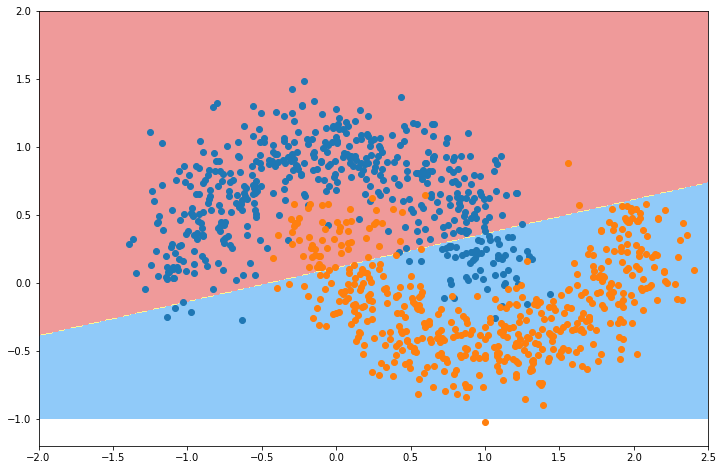

In [12]:
plt.figure(figsize=(12, 8))    
plot_decision_boundary(nn, [-2, 2.5, -1, 2])
plt.scatter(X[y==0, 0], X[y==0, 1])
plt.scatter(X[y==1, 0], X[y==1, 1])

In [13]:
y_predict = nn.predict(X_test)

In [14]:
y_predict[:10] # array([1, 1, 0, 1, 0, 0, 0, 1, 1, 1], dtype=int64)

array([1, 1, 0, 1, 0, 0, 0, 1, 1, 1], dtype=int64)

In [15]:
y_test[:10] # array([1, 1, 0, 1, 0, 0, 0, 1, 1, 1], dtype=int64)

array([1, 1, 0, 1, 0, 0, 0, 1, 1, 1], dtype=int64)

In [16]:
nn.accuracy(y_predict, y_test.flatten()) # 0.86

0.86